Working on evaluating the quality of the topics we have learned across a number of runs of the LDA model.

### Import packages

In [1]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [2]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [3]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [3]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



### Import a dictionary

Import a bag of words style dictionary for word counting analyses


In [6]:
model_spec = {"model_directory": "saved_models/topic20_minlength20_base",
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": 20,
              "num_topics": 20,
              "description": "test model"}

In [4]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [7]:
saved = Saved_state(model_spec)

In [8]:
# Restoring saved state

ldamodel = saved.ldamodel
qa_pairs= saved.qa_pairs
raw_qa_text = saved.raw_qa_text
corpus = saved.corpus
hellinger_sims = saved.hellinger_sims
dictionary = saved.dictionary
model_runtime = saved.model_runtime

print "Restored", model_spec["description"], "originally run at", model_runtime

Restored test model originally run at 2017-12-09 22:12:32.176898


In [9]:
# Display top 10 terms for each topic, with intrinsic UMass measure
# of coherence
ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 10)

[([(0.068563925839143877, u'quarter'),
   (0.051281775440546108, u'year'),
   (0.029050990360902168, u'margin'),
   (0.019875884381063889, u'first'),
   (0.016467304801215756, u'expect'),
   (0.015290766635550245, u'think'),
   (0.014543164344498923, u'second'),
   (0.014020016899665606, u'NUM'),
   (0.013462174589450513, u'half'),
   (0.011965256460273244, u'see')],
  -1.1794846699919062),
 ([(0.043859263094249264, u'market'),
   (0.037740502524278928, u'growth'),
   (0.025804702956057284, u'see'),
   (0.022996008463372339, u'busi'),
   (0.022607770019268336, u'think'),
   (0.015281571217101641, u'u'),
   (0.013364128866949553, u'year'),
   (0.013207761844962657, u'europ'),
   (0.011368699152513699, u'NUM'),
   (0.011304330270396418, u'look')],
  -1.1882724865153649),
 ([(0.038554639764875533, u'go'),
   (0.03850854224471241, u'think'),
   (0.02214809190313325, u'get'),
   (0.017020700698259009, u'year'),
   (0.016882405045071488, u'thing'),
   (0.012759122082361851, u'lot'),
   (0.01

In [10]:
# Display the coherence and topics in a little more readable form
scored_topics = ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 20)
for t in scored_topics:
    print
    print "U_mass Coherence is ", "{:3.2f}".format(t[1])
    print "Top 10 tokens in topic are:"
    for token_tuple in t[0]:
        print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])


U_mass Coherence is  -1.27
Top 10 tokens in topic are:
go        0.04
think     0.04
get       0.02
year      0.02
thing     0.02
lot       0.01
cost      0.01
time      0.01
look      0.01
right     0.01
see       0.01
say       0.01
know      0.01
us        0.01
like      0.01
kind      0.01
realli    0.01
got       0.01
back      0.01
good      0.01

U_mass Coherence is  -1.38
Top 10 tokens in topic are:
busi      0.03
think     0.02
continu   0.02
us        0.01
realli    0.01
product   0.01
well      0.01
make      0.01
custom    0.01
opportun  0.01
look      0.01
invest    0.01
market    0.01
work      0.01
valu      0.01
thing     0.01
term      0.01
also      0.01
drive     0.01
go        0.01

U_mass Coherence is  -1.59
Top 10 tokens in topic are:
quarter   0.07
year      0.05
margin    0.03
first     0.02
expect    0.02
think     0.02
second    0.01
NUM       0.01
half      0.01
see       0.01
look      0.01
last      0.01
go        0.01
fourth    0.01
impact    0.01
revenu 

## Extracting information to inspect topics and errors

In [12]:
cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = "u_mass", topn = 10)

In [13]:
umass_by_topic = cm.get_coherence_per_topic()
umass_by_topic

[-2.3713590609904478,
 -1.6270944386065846,
 -1.1794846699919062,
 -1.4033290494957751,
 -2.5218127764768736,
 -1.1882724865153649,
 -1.4229830860744079,
 -2.0026881828901457,
 -1.8098617141957354,
 -1.2334637234636505,
 -3.530683989246485,
 -6.0218491084458172,
 -2.508585957312933,
 -2.4109218380689184,
 -3.2737908138570164,
 -3.2697170459446077,
 -2.3091131200748953,
 -1.4831962209501304,
 -1.6388650117446013,
 -1.3359749128044207]

In [16]:
np.std(umass_by_topic)

1.1242025970902902

(array([ 1.,  0.,  0.,  0.,  0.,  3.,  0.,  5.,  2.,  9.]),
 array([-6.02184911, -5.53761266, -5.05337622, -4.56913978, -4.08490333,
        -3.60066689, -3.11643045, -2.632194  , -2.14795756, -1.66372111,
        -1.17948467]),
 <a list of 10 Patch objects>)

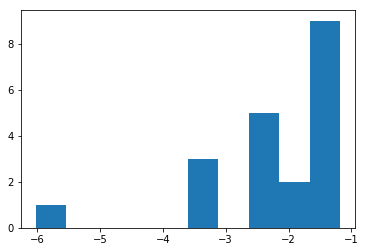

In [17]:
plt.hist(umass_by_topic)

In [31]:
# Build list of models to pull

model_spec_list = []

for num_topics in [10, 20, 40]:
    for min_sequence_length in [10, 20, 40]:
        
        model_dir = "saved_models/topic"+str(num_topics)+"_minlength"+str(min_sequence_length)+"_base"

        model_spec = {"model_directory": model_dir,
                      "qa_pair_directory": "saved_models/standard_preproc",
                      "preprocessing_function": "testLDA_pre_process_document",
                      "min_sequence_length": min_sequence_length,
                      "num_topics": num_topics,
                      "description": "Topics "+str(num_topics)+", Min Length "+str(min_sequence_length)+", Standard preprocessing"}
        
        model_spec_list.append(model_spec)

In [35]:
def get_coherences(model_spec, topn_list):
    '''Retrieves saved model from a model spec.  Returns a dict containing
       top n words, membership in topic per word and u_mass coherence
       measures for these top n words.'''
    
    coherences = dict()
    
    saved = Saved_state(model_spec)

    ldamodel = saved.ldamodel
    corpus = saved.corpus
    dictionary = saved.dictionary

    for n in topn_list:

        cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = "u_mass", topn = n)
        
#         coherences[n] = cm.get_coherence_per_topic()
        
        coherences[n] = ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = n)
        
    return coherences

In [36]:
# model_spec_list = [{"model_directory": "saved_models/topic20_minlength20_base",
#               "qa_pair_directory": "saved_models/standard_preproc",
#               "preprocessing_function": "testLDA_pre_process_document",
#               "min_sequence_length": 20,
#               "num_topics": 20,
#               "description": "test model"}]

topn_list = [10, 25, 50]

coherences = dict()

for model_spec in model_spec_list:
    
    start_time = time.time()
    
    print "evaluating coherence measures for", model_spec["description"]
    
    num_topics = model_spec["num_topics"]
    min_sequence_length = model_spec["min_sequence_length"]
    
    coherences[(num_topics, min_sequence_length)] = get_coherences(model_spec, topn_list)
    
    print "evaluation took", time.time() - start_time, "seconds"
    
    

evaluating coherence measures for Topics 10, Min Length 10, Standard preprocessing
evaluation took 24.5013349056 seconds
evaluating coherence measures for Topics 10, Min Length 20, Standard preprocessing
evaluation took 21.5444278717 seconds
evaluating coherence measures for Topics 10, Min Length 40, Standard preprocessing
evaluation took 12.076677084 seconds
evaluating coherence measures for Topics 20, Min Length 10, Standard preprocessing
evaluation took 27.4420278072 seconds
evaluating coherence measures for Topics 20, Min Length 20, Standard preprocessing
evaluation took 22.4334509373 seconds
evaluating coherence measures for Topics 20, Min Length 40, Standard preprocessing
evaluation took 13.5040578842 seconds
evaluating coherence measures for Topics 40, Min Length 10, Standard preprocessing
evaluation took 33.175303936 seconds
evaluating coherence measures for Topics 40, Min Length 20, Standard preprocessing
evaluation took 29.7595720291 seconds
evaluating coherence measures for 

In [37]:
coherences

{(10,
  10): {10: [([(0.0435005813872371, u'year'),
     (0.024992480686740239, u'think'),
     (0.022492623213370963, u'growth'),
     (0.019396692857356901, u'margin'),
     (0.019239991244469901, u'quarter'),
     (0.018728784094772858, u'see'),
     (0.015866692969706019, u'NUM'),
     (0.015085975898251433, u'go'),
     (0.015037057847117256, u'busi'),
     (0.013207392854993808, u'look')],
    -1.0048969645314536),
   ([(0.031607282141460628, u'think'),
     (0.023855964028736069, u'go'),
     (0.01455770636360942, u'get'),
     (0.012680546566976423, u'thing'),
     (0.011269340437079856, u'time'),
     (0.010513881053388092, u'us'),
     (0.010286807865565394, u'make'),
     (0.010083322185293803, u'know'),
     (0.0092016207402055312, u'say'),
     (0.0091575417064304488, u'realli')],
    -1.2719680718937922),
   ([(0.016457110891434191, u'cost'),
     (0.014847091026982107, u'invest'),
     (0.014731854582664329, u'think'),
     (0.013683646799935082, u'opportun'),
     (0.01

## Impact of hyperparameters on the topic quality

Using U_mass coherence as measure of topic quality.  Coherence is measured across a 
certain number of N words in the topic (ranked by the highest probability for that 
word in the topic).

Quality varies by topic.  Can summarize by showing mean and sd of coherence measures.

Showing for 3 different measures of N.

In [96]:
print "Mean and SD of topic Coherences for learned models"
print
print "{:^13}{:^21}{:^21}{:>11}{:>11}{:>11}".format("Num Topics", "Min Seq Length", 
                                            "N words for umass", "Mean", "SD", "SD/Mean")
print "{:^13}{:^21}{:^21}{:>11}{:>11}{:>11}".format("-"*11, "-"*17, "-"*17, "-"*6, "-"*6, "-"*6)

for n in [10, 25, 50]:
    print
    for t in sorted(coherences):
        u_mass_scores = [r[1] for r in coherences[t][n]]
        mean_score = np.mean(u_mass_scores)
        sd_score = np.std(u_mass_scores)
        print "{:^13}{:^21}{:^21}{:11.3f}{:11.3f}{:11.3f}".format(t[0], t[1], n, mean_score, sd_score, sd_score/mean_score)
        

Mean and SD of topic Coherences for learned models

 Num Topics     Min Seq Length      N words for umass         Mean         SD    SD/Mean
 -----------   -----------------    -----------------       ------     ------     ------

     10               10                   10               -1.632      0.336     -0.206
     10               20                   10               -1.459      0.236     -0.162
     10               40                   10               -1.168      0.187     -0.160
     20               10                   10               -2.434      1.164     -0.478
     20               20                   10               -2.227      1.124     -0.505
     20               40                   10               -1.592      0.419     -0.263
     40               10                   10               -2.959      1.424     -0.481
     40               20                   10               -2.849      1.444     -0.507
     40               40                   10            

## Evaluating how words in each topic contribute to the total

For each topic, we have a measure of the amount that each word contributes to that topic.

So we can sum up the probabilities across n words in the topic.  The total amount obviously
generally grows as the number of words we are considering grows.  But for the same number 
of N words it gives a sense of how concentrated the topic is in a few words.

In [91]:
print "Mean and SD of word probability for n words in learned topics"
print
print "{:^13}{:^21}{:^21}{:>11}{:>11}".format("Num Topics", "Min Seq Length", 
                                            "N words for umass", "Mean", "SD")
print "{:^13}{:^21}{:^21}{:>11}{:>11}".format("-"*11, "-"*17, "-"*17, "-"*6, "-"*6)


for n in [10, 25, 50]:
    print
    for t in sorted(coherences):
        topic_list = coherences[t][n]
        total_probs = list()    
        for topic_tuple in topic_list:
            word_tuples = topic_tuple[0]
            total_probs.append(sum(w[0] for w in word_tuples))
            
        mean_prob = np.mean(total_probs)
        sd_prob = np.std(total_probs)
            
        print "{:^13}{:^21}{:^21}{:11.3f}{:11.3f}".format(t[0], t[1], n, mean_prob, sd_prob)
        
#         print t, n, np.mean(total_probs), np.std(total_probs)

Mean and SD of word probability for n words in learned topics

 Num Topics     Min Seq Length      N words for umass         Mean         SD
 -----------   -----------------    -----------------       ------     ------

     10               10                   10                0.192      0.076
     10               20                   10                0.176      0.068
     10               40                   10                0.171      0.060
     20               10                   10                0.233      0.077
     20               20                   10                0.260      0.122
     20               40                   10                0.212      0.078
     40               10                   10                0.375      0.145
     40               20                   10                0.331      0.118
     40               40                   10                0.266      0.097

     10               10                   25                0.306      0.085

## Conclusions so far:

- higher minimum sequence lengths improve topic coherence.  This makes sense as the model has more meaningful documents to learn the topics from.
- high min squence length also reduces the sd of the coherences a lot, not just the mean.  
  
- higher numbers of topics reduce topic coherence.  I think this may be a natural consequence of the LDA but need to think about that some more.
- having more words in the u_mass calc increases the normalized sd

- higher numbers of topics increase the concentration of probability in the top n words in the topic.  This makes sense as the LDA has more topics to spread the words around into so can make each topic more discriminating.